process flow as follows：
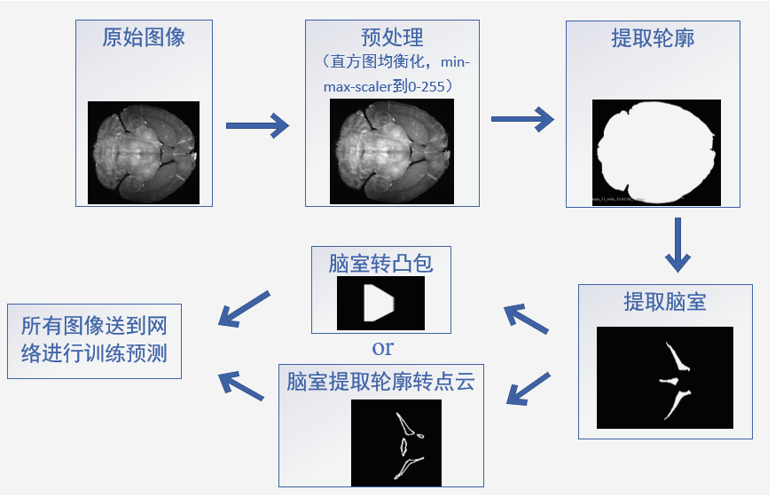


0. appoint the data path

In [5]:
from glob import glob
path_list = [r"C:\Users\IanX\Desktop\soma\181207_13_02_39\181207_13_02_39.tiff",
             r"C:\Users\IanX\Desktop\soma\181207_18_26_44\181207_18_26_44.tiff",
             r"C:\Users\IanX\Desktop\soma\181208_15_21_38\181208_15_21_38.tiff"
            ]
path_list = [i for i in path_list if "process" not in i and "outline" not in i]
constrain2label = {
                   "outline": 255,
                   "hole": 1,
                   "convex": 2,
                   "hole_pointcloud": 3,
                   "hole_landmark": 4,
                   "hpf": 5,
                   "cp": 6,
                   "csc": 7,
                   "bs": 8,
                   "cbx": 9,
                   "ctx": 10,
                   "cb": 11,
                   "act": 20,
                   "fr": 21,
                   "fx": 22,
                   "ipn": 23,
                   "mh_lh": 24
                   }
print(path_list)
import sys
sys.path.append("../..")
import numpy as np
import cv2
from tqdm import tqdm
import os
from ms_regnet.tools.io import read_tiff_stack, write_tiff_stack, read_nii

['C:\\Users\\IanX\\Desktop\\soma\\181207_13_02_39\\181207_13_02_39.tiff', 'C:\\Users\\IanX\\Desktop\\soma\\181207_18_26_44\\181207_18_26_44.tiff', 'C:\\Users\\IanX\\Desktop\\soma\\181208_15_21_38\\181208_15_21_38.tiff']


0.1 iamge may need rotate, mirror, the result brain's orientation should be like this
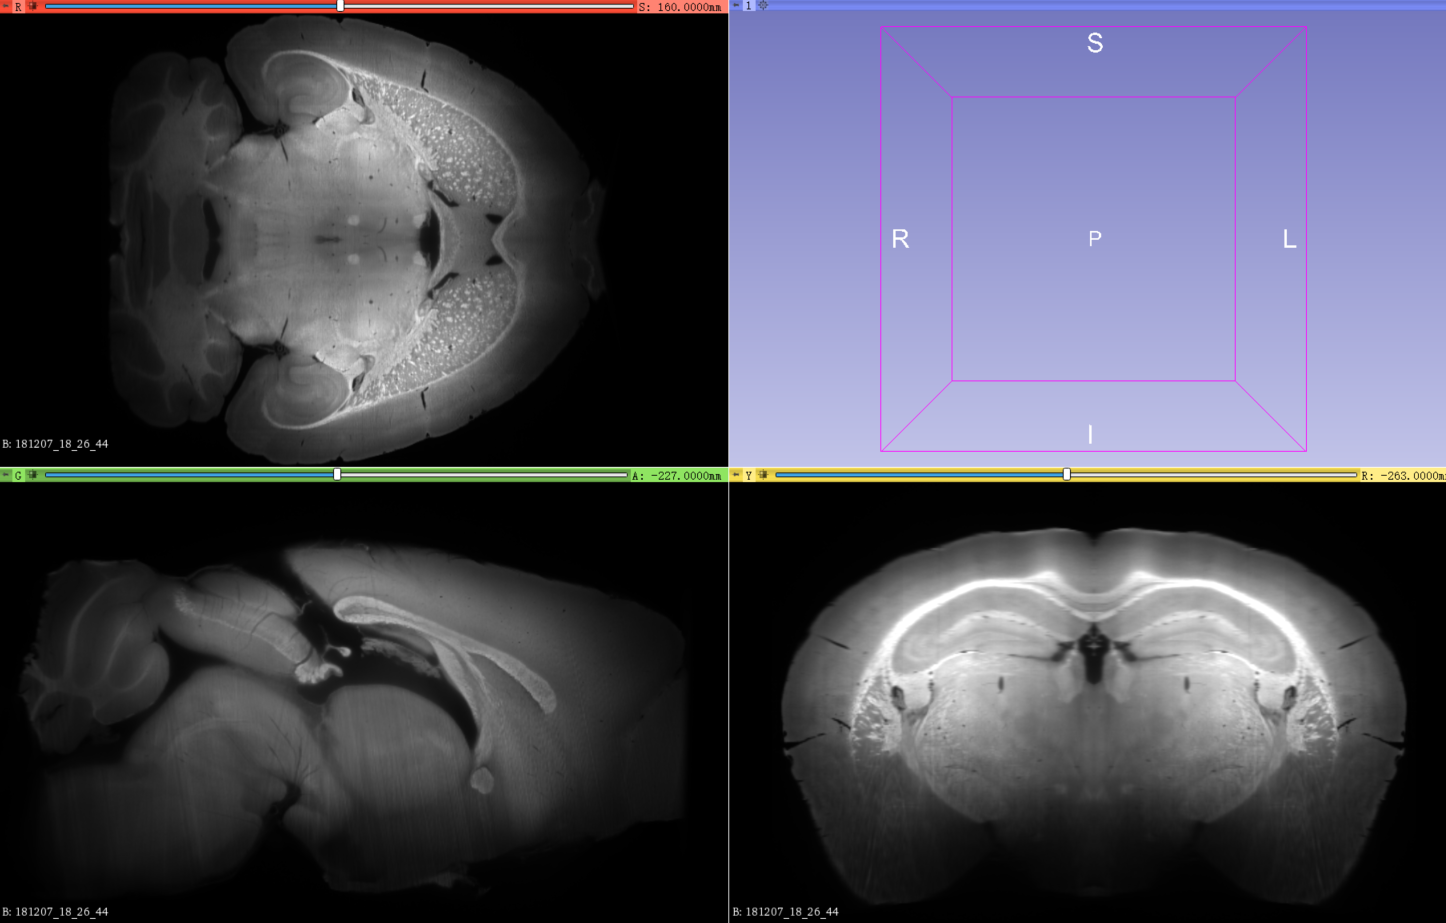

In [89]:
new_path_list = [
                r"D:\BaiduNetdiskDownload\fix\180706_RIGHT_488_40ET_18-05-05\data_180706_18_05_05_r3_m",
                ]
print(new_path_list)
for path in new_path_list:
    image = read_nii(path)
    image = np.transpose(image, (1, 2, 0))
    image = image[::-1, :, :]
    write_tiff_stack(image, r"D:\BaiduNetdiskDownload\fix\180706_RIGHT_488_40ET_18-05-05\180706_RIGHT_488_40ET_18-05-05_tra.tiff")

['D:\\BaiduNetdiskDownload\\fix\\180706_RIGHT_488_40ET_18-05-05\\data_180706_18_05_05_r3_m']
uint16


1. preprocess include histogram equalization, normalization

In [46]:
def process_my_data(AVGT):
    AVGT = AVGT.astype(np.float)
    AVGT = (AVGT-np.min(AVGT)) / (np.max(AVGT)-np.min(AVGT)) * 255
    AVGT = AVGT.astype(np.uint8)
    return AVGT

def handle_intensity3d(volume):
    print(np.shape(volume))
    H, W, C = volume.shape
    stack = [i for i in volume]  ## H个 W*C
    stack = np.concatenate(stack, axis=0) ## H*W, C
    print(np.shape(stack))
    stack = adaptive_history_equal(stack)
    volume = [stack[i*W: (i+1)*W] for i in range(H)]
    volume = np.reshape(volume, newshape=(H, W, C))
    return volume

def adaptive_history_equal(image):
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8, 8))
    img_eq = clahe.apply(image)
    return img_eq

new_path_list = [r"C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06.tiff"]
print(new_path_list)
for path in tqdm(new_path_list):
    data = read_tiff_stack(path)
    data = handle_intensity3d(data)
    data = process_my_data(data)
    write_tiff_stack(data, path.replace(".tiff", "_process.tiff"))


  0%|          | 0/1 [00:00<?, ?it/s]

['C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06.tiff']
(320, 456, 528)
(145920, 528)


<ipython-input-46-5b7c70464948>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AVGT = AVGT.astype(np.float)
100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


2. extract outline

In [47]:
from preprocess.outline import get_mask
new_path_list = [r"C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06.tiff"]
print(new_path_list)
for path in tqdm(new_path_list):
    proc_path = path.replace(".tiff", "_process.tiff")
    outline_path = path.replace(".tiff", "_outline.tiff")
    get_mask(proc_path, outline_path, thres=20, label=constrain2label["outline"])


  0%|          | 0/1 [00:00<?, ?it/s]

['C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06.tiff']


100%|██████████| 1/1 [07:21<00:00, 441.35s/it]


3. draw constrain from segmentation result if needed


In [11]:
def generate_hole(path, tarpath, l, label):
    image = read_nii(path)
    image[image!=1] = 0
    image[image==1] = label
    '''swap image if needed'''
    image = swap(image)
    new_image = np.zeros((320, 456, 528), dtype=np.uint8)
    new_image[l:l+image.shape[0], :, :] = image
    write_tiff_stack(new_image, tarpath)
    
def swap(img):
    '''swap image to right orientation'''
    # new_img = np.transpose(img, (1, 0, 2))  # (320, 512, 448)
    
    # new_img = [cv2.resize(i, (448, 528), interpolation=cv2.INTER_NEAREST) for i in new_img]
    # new_img = np.array(new_img) # (320, 528, 448)
    # new_img = np.transpose(new_img, (1, 0, 2)) # (528, 320, 448)
    # new_img = [cv2.resize(i, (456, 320), interpolation=cv2.INTER_NEAREST) for i in new_img]
    # new_img = np.array(new_img) # (528, 320, 456)
    # new_img = np.transpose(new_img, (1, 2, 0))
    # img = new_img
    # print(img.dtype)
    img = np.transpose(img, (1, 2, 0))
    img = img[::-1,:, :]
    return img
    
from glob import glob
new_path_list = glob(r"D:\mh\*\*.nii")
type = "cp"
print(new_path_list)
print(len(new_path_list))
for path in tqdm(new_path_list):
    generate_hole(path, 
                  os.path.join(os.path.split(path)[0], os.path.split(os.path.split(path)[0])[1]+"_"+type+".tiff"),
                  0,
                  label=constrain2label[type])

['D:\\mh\\180724_20180723O2_LEFT_488-2_100ET_16-13-41\\r1_CH_M_cea_result4_180724_O2_r3_m_CH.nii', 'D:\\mh\\180725_20180724C2_LEFT_488_100ET_20-02-09\\r1_CH_M_cea_result4_180725_C2_r3_m_CH.nii', 'D:\\mh\\180921_O11_488_LEFT_16-07-16\\r1_CH_M_cea_result4_180921_O11_r3_m_CH.nii', 'D:\\mh\\181207_10_39_06\\r1_CH_M_cea_result4_soma_181207_10_39_06_r6_m_CH.nii', 'D:\\mh\\181207_18_26_44\\r1_CH_M_cea_result4_soma_181207_18_26_44_r6_m_CH.nii', 'D:\\mh\\181208_15_21_38\\r1_CH_M_cea_result4_soma_181208_15_21_38_r6_m_CH.nii', 'D:\\mh\\190312_488_LP70_ET50_Z08_HF0_17-26-21\\r1_CH_M_cea_result4_s_190312_17_26_21_r3_m_CH.nii', 'D:\\mh\\190313_488_LP70_ET50_Z08_HF0_01-04-17\\r1_CH_M_cea_result4_s_190313_01_04_17_r3_m_CH.nii', 'D:\\mh\\190524_488_ET50_0HF_LP70_18-43-49\\r1_CH_M_cea_result4_s_190524_18_43_49_r3_m_CH.nii', 'D:\\mh\\zsl3\\r1_CH_M_cea_result4_bj_zsl3_r41_m_CH.nii', 'D:\\mh\\zsl8\\r1_CH_M_cea_result4_bj_zsl8_r41_m_CH.nii', 'D:\\mh\\zsl9\\r1_CH_M_cea_result4_bj_zsl9_r41_m_CH.nii']
12


  0%|          | 0/12 [00:00<?, ?it/s]

uint8


  8%|▊         | 1/12 [00:01<00:14,  1.35s/it]

uint8


 17%|█▋        | 2/12 [00:03<00:16,  1.69s/it]

uint8


 25%|██▌       | 3/12 [00:05<00:17,  1.95s/it]

uint8


 33%|███▎      | 4/12 [00:08<00:18,  2.31s/it]

uint8


 42%|████▏     | 5/12 [00:10<00:16,  2.30s/it]

uint8


 50%|█████     | 6/12 [00:12<00:13,  2.28s/it]

uint8


 58%|█████▊    | 7/12 [00:14<00:10,  2.03s/it]

uint8


 67%|██████▋   | 8/12 [00:16<00:08,  2.11s/it]

uint8


 75%|███████▌  | 9/12 [00:18<00:06,  2.07s/it]

uint8


 83%|████████▎ | 10/12 [00:21<00:04,  2.20s/it]

uint8


 92%|█████████▏| 11/12 [00:23<00:02,  2.34s/it]

uint8


100%|██████████| 12/12 [00:26<00:00,  2.17s/it]


4. set background to zero

In [9]:
def process_my_data(AVGT):
    AVGT = AVGT.astype(np.float)
    AVGT = (AVGT-np.min(AVGT)) / (np.max(AVGT)-np.min(AVGT)) * 255
    AVGT = AVGT.astype(np.uint8)
    return AVGT

def handle_intensity3d(volume):
    print(np.shape(volume))
    H, W, C = volume.shape
    stack = [i for i in volume]  ## H个 W*C
    stack = np.concatenate(stack, axis=0) ## H*W, C
    print(np.shape(stack))
    stack = adaptive_history_equal(stack)
    volume = [stack[i*W: (i+1)*W] for i in range(H)]
    volume = np.reshape(volume, newshape=(H, W, C))
    return volume

def adaptive_history_equal(image):
    clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8, 8))
    img_eq = clahe.apply(image)
    return img_eq

new_path_list = glob(r"C:\Users\haimiao\Desktop\fix\*\*.tiff")
new_path_list = [i for i in new_path_list if "outline" not in i ]
print(new_path_list)
print(len(new_path_list))
for path in tqdm(new_path_list):
    data = read_tiff_stack(path)
    outline = read_tiff_stack(path.replace("_tra.tiff", "_outline.tiff"))
    data[outline==0] = 0 
    data = handle_intensity3d(data)
    data = process_my_data(data)
    write_tiff_stack(data, path.replace(".tiff", "_process.tiff"))


  0%|          | 0/3 [00:00<?, ?it/s]

['C:\\Users\\haimiao\\Desktop\\fix\\190312_488_LP70_ET50_Z08_HF0_17-26-21\\190312_488_LP70_ET50_Z08_HF0_17-26-21_tra.tiff', 'C:\\Users\\haimiao\\Desktop\\fix\\190313_488_LP70_ET50_Z08_HF0_01-04-17\\190313_488_LP70_ET50_Z08_HF0_01-04-17_tra.tiff', 'C:\\Users\\haimiao\\Desktop\\fix\\190524_488_ET50_0HF_LP70_18-43-49\\190524_488_ET50_0HF_LP70_18-43-49_tra.tiff']
3
(320, 456, 528)
(145920, 528)


<ipython-input-9-1b2c1acedf2d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  AVGT = AVGT.astype(np.float)
 33%|███▎      | 1/3 [00:03<00:06,  3.15s/it]

(320, 456, 528)
(145920, 528)



 67%|██████▋   | 2/3 [00:06<00:03,  3.13s/it]

(320, 456, 528)
(145920, 528)


100%|██████████| 3/3 [00:09<00:00,  3.14s/it]


5. process mask result base on the outline

In [7]:
new_path_list = glob(r"C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\*06_*.tiff")
new_path_list = [i for i in new_path_list if 'outline' not in i and 'process' not in i and 'tra' not in i]
print(new_path_list)
print(len(new_path_list))
for path in tqdm(new_path_list):
    data = read_tiff_stack(path)
    outline_path = '_'.join(path.split("_")[:-1])+"_outline.tiff"
    print(outline_path)
    outline = read_tiff_stack(outline_path)
    data[outline==0] = 0 
    write_tiff_stack(data, path)


  0%|          | 0/8 [00:00<?, ?it/s]

['C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_bs.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_cb.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_cbx.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_cp.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_csc.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\\FileStorage\\File\\2022-04\\181207_10_39_06\\181207_10_39_06\\181207_10_39_06_ctx.tiff', 'C:\\Users\\haimiao\\Documents\\WeChat Files\\wxid_tqakwb2ixv5g22\


 12%|█▎        | 1/8 [00:01<00:11,  1.61s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 25%|██▌       | 2/8 [00:02<00:08,  1.47s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 38%|███▊      | 3/8 [00:04<00:07,  1.40s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 50%|█████     | 4/8 [00:05<00:05,  1.37s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 62%|██████▎   | 5/8 [00:06<00:04,  1.36s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 75%|███████▌  | 6/8 [00:08<00:02,  1.36s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff



 88%|████████▊ | 7/8 [00:09<00:01,  1.36s/it]

C:\Users\haimiao\Documents\WeChat Files\wxid_tqakwb2ixv5g22\FileStorage\File\2022-04\181207_10_39_06\181207_10_39_06\181207_10_39_06_outline.tiff


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]
